# Assignment 2

In [1]:
# All libraries required
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers

2024-05-14 23:41:51.124999: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-14 23:41:51.845461: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 23:41:54.028407: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Tensorflow Version
print(tf.__version__)

2.16.1


In [3]:
# Allocate more memory - https://www.tensorflow.org/guide/gpu

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2024-05-14 23:41:56.293774: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-14 23:41:57.033735: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-14 23:41:57.033890: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-14 23:41:57.130532: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-14 23:41:57.131007: I external/local_xla/xla/stream_executor

In [4]:
# Plotting history graph
def plot_loss(history, which='loss'):
    plt.plot(history.history[which], label='train')
    try:
        plt.plot(history.history['val_'+which], label='validation')
    except:
        None
    plt.xlabel('Epoch')
    plt.ylabel(which)
    plt.legend()
    plt.grid(True)

## Model 1: Grayscale

In [5]:
# Get data - https://www.tensorflow.org/tutorials/load_data/images#load_data_using_a_keras_utility

# Parameters
batch_size = 125912
IMG_SIZE = (512, 512)
data_dir = './hagridset'
seed_no = 388741
validation_split = 0.3

# Dataset - https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker

# Auto split to training set (70%)
training_data_set = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       image_size = IMG_SIZE,
                                                       validation_split = validation_split,
                                                       subset = 'training',
                                                       seed = seed_no,
                                                       color_mode = 'grayscale',
                                                       shuffle = True)

# Auto split to validation set and test set (30%)
validation_data_set = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       image_size = IMG_SIZE,
                                                       validation_split = validation_split,
                                                       subset = 'validation',
                                                       seed = seed_no,
                                                       color_mode = 'grayscale',
                                                       shuffle = True)

# Split further to validation set (10%) and test set (20%)
validation_batches = tf.data.experimental.cardinality(validation_data_set)
test_data_set = validation_data_set.take((2 * validation_batches) // 3)
validation_data_set = validation_data_set.skip((2 * validation_batches) // 3)

Found 125912 files belonging to 18 classes.
Using 88139 files for training.
Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


In [6]:
# Number of classes
num_classes = len(training_data_set.class_names)
num_classes

# Model building
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1)))
model.add(layers.Conv2D(12, 3, strides=2, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(18, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(24, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(48, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(96, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(192, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(192, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 12)   │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 18)   │         1,962 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 18)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 24)     │         3,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │         6,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 48)     │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 96)       │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 128)      │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 2, 2, 192)      │       221,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 1, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 192)            │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         3,474 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 441,004 (1.68 MB)

 Trainable params: 441,004 (1.68 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history = model.fit(training_data_set, validation_data=validation_data_set, epochs=50, callbacks=[callback])

Epoch 1/100


I0000 00:00:1715726707.109339   51175 service.cc:145] XLA service 0x7f755c011a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715726707.109579   51175 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-05-14 23:45:07.422657: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-14 23:45:07.823697: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


   6/2755 ━━━━━━━━━━━━━━━━━━━━ 1:08 25ms/step - accuracy: 0.0559 - loss: 5.9950 

I0000 00:00:1715726716.009057   51175 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2755/2755 ━━━━━━━━━━━━━━━━━━━━ 131s 44ms/step - accuracy: 0.1675 - loss: 2.5950 - val_accuracy: 0.5359 - val_loss: 1.4378
Epoch 2/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 138s 50ms/step - accuracy: 0.6112 - loss: 1.1999 - val_accuracy: 0.6831 - val_loss: 0.9953
Epoch 3/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 136s 49ms/step - accuracy: 0.7161 - loss: 0.8825 - val_accuracy: 0.6976 - val_loss: 0.9534
Epoch 4/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 135s 49ms/step - accuracy: 0.7580 - loss: 0.7497 - val_accuracy: 0.7513 - val_loss: 0.7957
Epoch 5/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 136s 49ms/step - accuracy: 0.7840 - loss: 0.6625 - val_accuracy: 0.7449 - val_loss: 0.8512
Epoch 6/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 127s 46ms/step - accuracy: 0.7989 - loss: 0.6203 - val_accuracy: 0.7587 - val_loss: 0.7741
Epoch 7/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 122s 44ms/step - accuracy: 0.8156 - loss: 0.5703 - val_accuracy: 0.7735 - val_loss: 0.7692
Epoch 8/100
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 118s 43ms/step - accuracy: 0.82

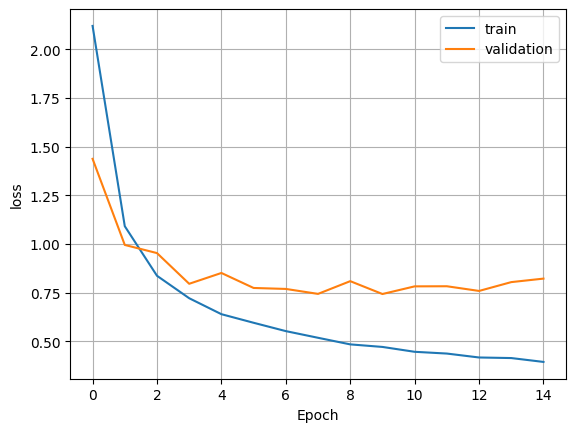

In [11]:
plot_loss(history)

In [12]:
result1 = model.evaluate(test_data_set)
result1

787/787 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7797 - loss: 0.7237


[0.7092766165733337, 0.7833148241043091]

## Model 2: Colour

In [13]:
# Get data - https://www.tensorflow.org/tutorials/load_data/images#load_data_using_a_keras_utility

# Parameters
batch_size = 125912
IMG_SIZE = (512, 512)
data_dir = './hagridset'
seed_no = 388741
validation_split = 0.3

# Dataset - https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker

# Auto split to training set (70%)
training_data_set = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       image_size = IMG_SIZE,
                                                       validation_split = validation_split,
                                                       subset = 'training',
                                                       seed = seed_no,
                                                       color_mode = "rgb",
                                                       label_mode='categorical',
                                                       shuffle = True)

# Auto split to validation set and test set (30%)
validation_data_set = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       image_size = IMG_SIZE,
                                                       validation_split = validation_split,
                                                       subset = 'validation',
                                                       seed = seed_no,
                                                       color_mode = "rgb",
                                                       label_mode='categorical',
                                                       shuffle = True)

# Split further to validation set (10%) and test set (20%)
validation_batches = tf.data.experimental.cardinality(validation_data_set)
test_data_set = validation_data_set.take((2 * validation_batches) // 3)
validation_data_set = validation_data_set.skip((2 * validation_batches) // 3)

Found 125912 files belonging to 18 classes.
Using 88139 files for training.
Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


In [14]:
# Model building
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
model2.add(layers.Conv2D(12, 3, strides=2, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D())
model2.add(layers.Conv2D(18, 3, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D())
model2.add(layers.Conv2D(24, 3, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D())
model2.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D())
model2.add(layers.Conv2D(48, 3, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D())
model2.add(layers.Conv2D(96, 3, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D())
model2.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D())
model2.add(layers.Conv2D(192, 3, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D())
model2.add(layers.Flatten())
model2.add(layers.Dense(192, activation='relu'))
model2.add(layers.Dense(num_classes, activation='softmax'))

In [15]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 256, 256, 12)   │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 128, 128, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 18)   │         1,962 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 18)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 24)     │         3,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 32)     │         6,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 48)     │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 8, 8, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 8, 8, 96)       │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 4, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 4, 4, 128)      │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 2, 2, 192)      │       221,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 1, 1, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 192)            │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │         3,474 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 441,220 (1.68 MB)

 Trainable params: 441,220 (1.68 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model2.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history2 = model2.fit(training_data_set, validation_data=validation_data_set, epochs=50, callbacks=[callback])

Epoch 1/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 180s 62ms/step - accuracy: 0.1701 - loss: 2.6178 - val_accuracy: 0.6746 - val_loss: 1.0363
Epoch 2/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 169s 61ms/step - accuracy: 0.6981 - loss: 0.9620 - val_accuracy: 0.7615 - val_loss: 0.7589
Epoch 3/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 169s 61ms/step - accuracy: 0.7776 - loss: 0.7075 - val_accuracy: 0.7921 - val_loss: 0.6647
Epoch 4/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 174s 63ms/step - accuracy: 0.8049 - loss: 0.6221 - val_accuracy: 0.8109 - val_loss: 0.6163
Epoch 5/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 175s 63ms/step - accuracy: 0.8277 - loss: 0.5469 - val_accuracy: 0.8039 - val_loss: 0.6416
Epoch 6/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 171s 62ms/step - accuracy: 0.8421 - loss: 0.5002 - val_accuracy: 0.7974 - val_loss: 0.7049
Epoch 7/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 161s 59ms/step - accuracy: 0.8509 - loss: 0.4837 - val_accuracy: 0.7979 - val_loss: 0.6648
Epoch 8/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 148s 54ms/step - accuracy: 

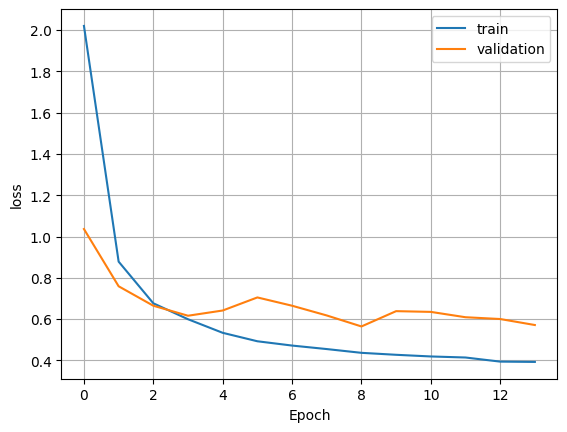

In [18]:
plot_loss(history2)

In [19]:
result2 = model2.evaluate(test_data_set)
result2

787/787 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - accuracy: 0.8376 - loss: 0.5571


[0.5495814681053162, 0.8385879993438721]

# Model 3: Transfer Learning

In [20]:
# Get data - https://www.tensorflow.org/tutorials/load_data/images#load_data_using_a_keras_utility

# Parameters
batch_size = 125912
IMG_SIZE = (224, 224)
data_dir = './hagridset'
seed_no = 388741
validation_split = 0.3

# Dataset - https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker

# Auto split to training set (70%)
training_data_set = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       image_size = IMG_SIZE,
                                                       validation_split = validation_split,
                                                       subset = 'training',
                                                       seed = seed_no,
                                                       color_mode = "rgb",
                                                       label_mode='categorical',
                                                       shuffle = True)

# Auto split to validation set and test set (30%)
validation_data_set = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       image_size = IMG_SIZE,
                                                       validation_split = validation_split,
                                                       subset = 'validation',
                                                       seed = seed_no,
                                                       color_mode = "rgb",
                                                       label_mode='categorical',
                                                       shuffle = True)

# Split further to validation set (10%) and test set (20%)
validation_batches = tf.data.experimental.cardinality(validation_data_set)
test_data_set = validation_data_set.take((2 * validation_batches) // 3)
validation_data_set = validation_data_set.skip((2 * validation_batches) // 3)

Found 125912 files belonging to 18 classes.
Using 88139 files for training.
Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


In [21]:
# Parameters
num_classes = len(training_data_set.class_names)

# Building the Model
model3_base = tf.keras.applications.VGG16(
    weights='imagenet',
    input_shape=(IMG_SIZE[0], IMG_SIZE[1],3),
    include_top=False)
model3_base.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1],3))
x = model3_base(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model3 = tf.keras.Model(inputs, outputs)

# Compile the Model
model3.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [22]:
model3.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 18)             │         9,234 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,723,922 (56.17 MB)

 Trainable params: 9,234 (36.07 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [23]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history3 = model3.fit(training_data_set, validation_data=validation_data_set, epochs=50, callbacks=[callback])

Epoch 1/50


I0000 00:00:1715731225.086218   84183 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_753', 20 bytes spill stores, 20 bytes spill loads



2754/2755 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.4084 - loss: 2.6814

I0000 00:00:1715731617.240606   86900 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_753', 4 bytes spill stores, 4 bytes spill loads



2755/2755 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.4084 - loss: 2.6811

I0000 00:00:1715731692.203793   87490 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_210', 4 bytes spill stores, 4 bytes spill loads



2755/2755 ━━━━━━━━━━━━━━━━━━━━ 482s 169ms/step - accuracy: 0.4085 - loss: 2.6807 - val_accuracy: 0.6155 - val_loss: 1.2842
Epoch 2/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 456s 165ms/step - accuracy: 0.6364 - loss: 1.1941 - val_accuracy: 0.6376 - val_loss: 1.2066
Epoch 3/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 459s 166ms/step - accuracy: 0.6499 - loss: 1.1525 - val_accuracy: 0.6390 - val_loss: 1.2020
Epoch 4/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 459s 167ms/step - accuracy: 0.6536 - loss: 1.1473 - val_accuracy: 0.6460 - val_loss: 1.2008
Epoch 5/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 457s 166ms/step - accuracy: 0.6540 - loss: 1.1534 - val_accuracy: 0.6398 - val_loss: 1.2360
Epoch 6/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 460s 167ms/step - accuracy: 0.6547 - loss: 1.1464 - val_accuracy: 0.6389 - val_loss: 1.2348
Epoch 7/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 463s 168ms/step - accuracy: 0.6561 - loss: 1.1488 - val_accuracy: 0.6441 - val_loss: 1.2126
Epoch 8/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 462s 168ms/step - accuracy: 0.6

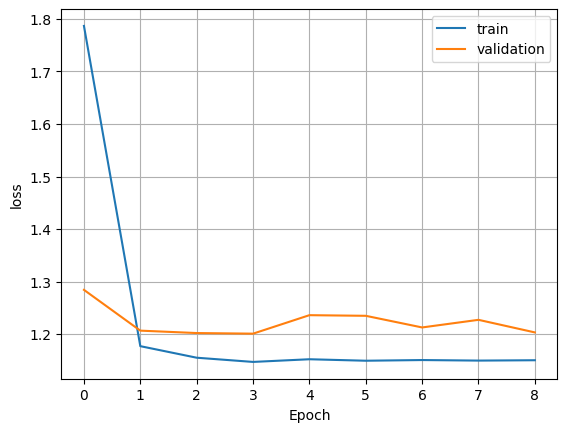

In [24]:
plot_loss(history3)

In [25]:
result3 = model3.evaluate(test_data_set)
result3

787/787 ━━━━━━━━━━━━━━━━━━━━ 112s 142ms/step - accuracy: 0.6479 - loss: 1.1817


[1.1924562454223633, 0.650532066822052]

# Choosing the best model

In [26]:
print("Model 1 (Manual Greyscale): "+str(result1[1]))
print("Model 2 (Manual RGB): "+str(result2[1]))
print("Model 3 (Transfer Learning): "+str(result3[1]))

model_list = [model, model2, model3]
results_acc_list = [result1[1], result2[1], result3[1]]

Model 1 (Manual Greyscale): 0.7833148241043091
Model 2 (Manual RGB): 0.8385879993438721
Model 3 (Transfer Learning): 0.650532066822052


In [27]:
# Get best accuracy
best_accuracy = max(results_acc_list)
best_accuracy_index = results_acc_list.index(best_accuracy)
print("Best Accuracy: "+str(best_accuracy))
print("Model Number: "+str(best_accuracy_index+1))

best_model = model_list[best_accuracy_index]

Best Accuracy: 0.8385879993438721
Model Number: 2


# Test with own images
(tbd on wednesday)